## Imports

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from re import search
import matplotlib.pyplot as plt
from mlp_helper import mlp_train
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn import preprocessing

## Helper functions

In [2]:
def get_subdirectories(folder_path):
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

def get_num(text):
    if isinstance(text, list):
        numbers = []
        for item in text:
            number_str = search(r'\d+(?=[^\d]*\.csv)', str(item))[0]
            if number_str:
                numbers.append(number_str)
        return numbers
    else:
        number_str = search(r'\d+(?=[^\d]*\.csv)', str(text))[0]
        return number_str if number_str else None

def read_csv_to_tensor(file_path, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    dataframe = pd.read_csv(file_path)

    # Convert DataFrame to a tensor
    tensor = torch.tensor(dataframe.values)

    # Store the tensor in the dictionary with the specified variable name
    tensors_dict[tensor_name] = tensor

def read_csv_to_tensor2(file_path):#, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    return pd.read_csv(file_path)

def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                print(files)
                name_variableR = i+'_'+j+'_'+label[index_k]
                # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())
                    print(f'label df:\n{label_df}')
                    print(f'index_start:\n{index_start}')
                    print(f'index_end:\n{index_end}')
            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # pd.set_option('display.max_rows', None)
            # print(label_df)
            # print(main_df.iloc[1067:1228])
            # pd.set_option('display.max_rows', 10)
            # print(f'main df:\n{main_df}')

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,2,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)
            
    
            steps1=[]
            steps2=[]
            step = False
            for index, row in main_df.iterrows():
                if row['label'] == 1:
                    step = not step  # Toggle the value of 'step'
                if step:
                    steps1.append(index)
                else:
                    steps2.append(index)
            
            main_df['label'] = main_df.apply(lambda row: 1 if row.name in steps1 else 0, axis=1)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],self.dataY[idx:idx+self.time_steps])

# Custom dataset class
class MyDatasetLSTM(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],torch.mode(self.dataY[idx:idx+self.time_steps])[0])

# Custom dataset class testing
class MyDatasetLSTM_testing(Dataset):
    def __init__(self, data, time_steps):
        self.data = data
        self.time_steps = time_steps

    def __len__(self):
        return len(self.data) - self.time_steps + 1

    def __getitem__(self, idx):
        return self.data[idx:idx+self.time_steps]


## Data reading / importing

In [3]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,0]
labelssteps = tensor_unified[:,7]
print(labelssteps)
labels = labels.long()
labelssteps = labelssteps.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_8/ClippedawindaRecording_20230217130617.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_8/awindaRecording_20230217130617.csv.stepMixed']
label df:
     start    end
0     1067   1118
1     1176   1226
2     1273   1319
3     1363   1411
4     1454   1498
..     ...    ...
645  28848  28887
646  28931  28971
647  29017  29059
648  29109  29152
649  29198  29247

[650 rows x 2 columns]
index_start:
[1067, 1119, 1176, 1227, 1273, 1320, 1363, 1412, 1454, 1499, 1544, 1591, 1636, 1679, 1720, 1763, 1806, 1847, 1889, 1932, 1974, 2017, 2058, 2099, 2140, 2182, 2225, 2267, 2306, 2347, 2389, 2430, 2470, 2510, 2548, 2589, 2629, 2668, 2708, 2748, 2787, 2828, 2868, 2909, 2949, 2990, 3030, 3071, 3111, 3151, 3192, 3233, 3271, 3310, 3350, 3396, 3451, 3503, 3556, 3611, 3678, 3727, 3778, 3847, 3910, 3963, 4021, 4080, 4132, 4177, 4222, 4269, 4316, 4361, 4402, 4443, 4483, 4523, 4562, 4603, 4641, 4678, 4715, 4753, 4792, 483

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_7/ClippedawindaRecording_20230206175311.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_7/awindaRecording_20230206175311.csv.stepMixed']
label df:
     start    end
0      676    725
1      771    810
2      854    894
3      939    979
4     1023   1063
..     ...    ...
834  48281  48326
835  48375  48423
836  48472  48520
837  48571  48618
838  48663  48700

[839 rows x 2 columns]
index_start:
[622, 676, 726, 771, 811, 854, 895, 939, 980, 1023, 1064, 1106, 1149, 1190, 1233, 1275, 1317, 1359, 1399, 1441, 1481, 1523, 1563, 1606, 1647, 1689, 1729, 1771, 1811, 1854, 1893, 1935, 1976, 2017, 2058, 2102, 2143, 2185, 2226, 2268, 2309, 2352, 2394, 2436, 2479, 2522, 2564, 2606, 2647, 2689, 2729, 2772, 2813, 2855, 2897, 2941, 2983, 3025, 3064, 3106, 3146, 3188, 3227, 3269, 3309, 3350, 3390, 3431, 3473, 3514, 3553, 3596, 3635, 3677, 3718, 3759, 3799, 3840, 3881, 3924, 3965, 4007, 4048, 4093, 4135, 4178, 4218, 

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_7/ClippedawindaRecording_20230124145256.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_7/awindaRecording_20230124145256.csv.stepMixed']
label df:
     start    end
0      651    705
1      766    818
2      871    920
3      972   1022
4     1074   1125
..     ...    ...
256  18368  18421
257  18473  18523
258  18575  18625
259  18677  18728
260  18781  18831

[261 rows x 2 columns]
index_start:
[651, 706, 766, 819, 871, 921, 972, 1023, 1074, 1126, 1179, 1231, 1285, 1338, 1987, 2042, 2113, 2165, 2223, 2275, 2328, 2381, 2432, 2481, 2532, 2582, 2632, 2682, 2731, 2781, 2833, 2883, 2934, 2985, 3035, 3086, 3139, 3186, 4665, 4718, 4781, 4837, 4891, 4945, 5000, 5056, 5116, 5169, 5234, 5292, 5352, 5410, 5461, 5514, 5565, 5617, 5669, 5720, 5771, 5823, 5873, 5924, 5973, 6024, 6074, 6126, 6177, 6229, 6280, 6333, 6387, 7174, 7230, 7289, 7343, 7398, 7449, 7504, 7556, 7609, 7666, 7715, 7772, 7824, 7878, 7929, 7988

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_7/ClippedawindaRecording_20230206162842.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_7/awindaRecording_20230206162842.csv.stepMixed']
label df:
     start    end
0      641    690
1      740    783
2      827    868
3      912    953
4      995   1037
..     ...    ...
537  24998  25053
538  25114  25168
539  25223  25276
540  25332  25388
541  25456  25512

[542 rows x 2 columns]
index_start:
[641, 691, 740, 784, 827, 869, 912, 954, 995, 1038, 1082, 1125, 1169, 1212, 1255, 1298, 1341, 1384, 1425, 1465, 1504, 1541, 1580, 1619, 1657, 1694, 1732, 1770, 1809, 1846, 1881, 1915, 1949, 1982, 2017, 2050, 2085, 2118, 2154, 2189, 2224, 2259, 2294, 2330, 2367, 2403, 2443, 2483, 2525, 2568, 2610, 2652, 2696, 2740, 2784, 2829, 2873, 2917, 2961, 3005, 3047, 3091, 3137, 3180, 3225, 3270, 3318, 3366, 3414, 3456, 3503, 3546, 3585, 3627, 3666, 3708, 3749, 3793, 3837, 3889, 3932, 3970, 4012, 4056, 4097, 4140, 4180, 

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_12/ClippedawindaRecording_20230403155903.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_12/awindaRecording_20230403155903.csv.stepMixed']
label df:
     start    end
0     1043   1085
1     1131   1173
2     1218   1264
3     1307   1350
4     1395   1436
..     ...    ...
517  31952  32004
518  32047  32091
519  32134  32179
520  32224  32273
521  32326  32382

[522 rows x 2 columns]
index_start:
[993, 1043, 1086, 1131, 1174, 1218, 1265, 1307, 1351, 1395, 1437, 1480, 1522, 1565, 1606, 1649, 1690, 1734, 1775, 1822, 1859, 1898, 1940, 1983, 2028, 2071, 2115, 2157, 2200, 2244, 2296, 2337, 2383, 2423, 2470, 2512, 2556, 2598, 2639, 2683, 2727, 2772, 2828, 2866, 2912, 2949, 2999, 3042, 3086, 3131, 3173, 3216, 3259, 3305, 3360, 3402, 3454, 3496, 3546, 3598, 3653, 3702, 3754, 3805, 3861, 3911, 3970, 4017, 4065, 4117, 4164, 4216, 4262, 4312, 4355, 4406, 4453, 4503, 6568, 6610, 6658, 6708, 6751, 6797, 6840, 68

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_2/ClippedawindaRecording_20230217132921.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_2/awindaRecording_20230217132921.csv.stepMixed']
label df:
     start    end
0      557    606
1      650    690
2      731    767
3      797    819
4      842    861
..     ...    ...
595  22571  22620
596  22669  22714
597  22759  22805
598  22850  22908
599  22964  23016

[600 rows x 2 columns]
index_start:
[557, 607, 650, 691, 731, 768, 797, 820, 842, 862, 884, 904, 926, 948, 970, 990, 1012, 1036, 1064, 1101, 1125, 1146, 1168, 1190, 1213, 1236, 1259, 1282, 1306, 1328, 1352, 1395, 1438, 1480, 1521, 1568, 1619, 1680, 1733, 1781, 1825, 1865, 1904, 1943, 1981, 2018, 2055, 2091, 2128, 2165, 2201, 2238, 2275, 2313, 2352, 2389, 2427, 2464, 2501, 2537, 2576, 2614, 2652, 2689, 2728, 2765, 2803, 2840, 2878, 2915, 2953, 2989, 3026, 3063, 3101, 3137, 3174, 3210, 3248, 3285, 3323, 3360, 3398, 3435, 3473, 3509, 3547, 3584, 3

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_3/ClippedawindaRecording_20230217125431.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_3/awindaRecording_20230217125431.csv.stepMixed']
label df:
     start    end
0      732    812
1      965   1010
2     1053   1096
3     1137   1180
4     1221   1262
..     ...    ...
747  30378  30417
748  30459  30499
749  30541  30580
750  30622  30662
751  30708  30742

[752 rows x 2 columns]
index_start:
[732, 858, 965, 1011, 1053, 1097, 1137, 1181, 1221, 1263, 1304, 1345, 1385, 1426, 1466, 1507, 1546, 1587, 1626, 1667, 1707, 1751, 1792, 1837, 1878, 1922, 1962, 2006, 2045, 2086, 2126, 2168, 2208, 2250, 2290, 2331, 2370, 2410, 2450, 2491, 2530, 2570, 2610, 2650, 2689, 2730, 2769, 2810, 2851, 2891, 2931, 2971, 3011, 3051, 3090, 3132, 3171, 3210, 3249, 3289, 3326, 3365, 3412, 3460, 3505, 3553, 3598, 3647, 3693, 3741, 3786, 3834, 3883, 3939, 3976, 4024, 4067, 4114, 4158, 4208, 4254, 4302, 4349, 4397, 4445, 4497, 

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/ClippedawindaRecording_20230124152114.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/awindaRecording_20230124152114.csv.stepMixed']
label df:
     start    end
0      684    733
1      786    830
2      876    920
3      965   1007
4     1054   1095
..     ...    ...
593  39165  39215
594  39266  39314
595  39361  39408
596  39457  39503
597  39557  39601

[598 rows x 2 columns]
index_start:
[684, 734, 786, 831, 876, 921, 965, 1008, 1054, 1096, 1136, 1176, 1215, 1255, 1294, 1334, 1374, 1413, 1453, 1492, 1533, 1575, 1614, 1656, 1697, 1739, 1781, 1823, 1865, 1907, 1947, 1988, 2029, 2071, 2112, 2153, 2196, 2239, 2283, 2328, 2371, 2413, 2457, 2502, 2549, 2598, 7177, 7232, 7279, 7321, 7364, 7407, 7450, 7491, 7535, 7575, 7615, 7655, 7696, 7736, 7776, 7817, 7857, 7897, 7939, 7980, 8023, 8065, 8106, 8147, 8188, 8230, 8271, 8312, 8351, 8393, 8434, 8474, 8516, 8557, 8598, 8641, 8681, 8724, 8767, 8812, 8857

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/ClippedawindaRecording_20230124153538.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/awindaRecording_20230124153538.csv.stepMixed']
label df:
     start    end
0      703    751
1      795    836
2      880    921
3      963   1007
4     1050   1092
..     ...    ...
241  15526  15569
242  15615  15658
243  15704  15750
244  15796  15844
245  15897  15940

[246 rows x 2 columns]
index_start:
[651, 703, 752, 795, 837, 880, 922, 963, 1008, 1050, 1093, 1134, 1176, 1217, 1258, 1299, 1339, 1380, 1422, 1464, 1505, 1547, 1588, 1627, 1668, 1708, 1749, 1789, 1829, 1870, 1912, 1955, 1998, 2040, 2083, 2126, 2171, 2215, 2257, 2297, 2350, 2398, 2445, 2491, 2538, 2585, 2638, 2700, 2755, 2812, 2877, 2934, 2988, 3050, 3112, 3169, 3230, 3289, 3349, 3408, 3472, 3540, 3592, 3644, 3699, 3743, 3809, 3866, 3922, 3977, 4033, 4089, 4147, 4204, 4274, 4324, 4380, 4427, 4487, 4543, 4597, 4652, 4706, 4760, 4818, 4872, 4937,

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/ClippedawindaRecording_20230206162219.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/awindaRecording_20230206162219.csv.stepMixed']
label df:
     start    end
0      843    892
1      937    979
2     1023   1066
3     1109   1155
4     1200   1243
..     ...    ...
438  19484  19522
439  19563  19601
440  19642  19681
441  19723  19763
442  19810  19849

[443 rows x 2 columns]
index_start:
[798, 843, 893, 937, 980, 1023, 1067, 1109, 1156, 1200, 1244, 1285, 1327, 1367, 1403, 1442, 1482, 1519, 1556, 1589, 1626, 1660, 1695, 1730, 1768, 1805, 1847, 1892, 1936, 1980, 2024, 2068, 2111, 2154, 2192, 2235, 2273, 2313, 2348, 2383, 2420, 2459, 2497, 2533, 2574, 2615, 2656, 2698, 2743, 2788, 3244, 3291, 3337, 3381, 3421, 3462, 3502, 3542, 3582, 3622, 3661, 3701, 3741, 3782, 3822, 3863, 3902, 3943, 3982, 4023, 4063, 4102, 4142, 4182, 4220, 4261, 4300, 4340, 4380, 4420, 4459, 4497, 4535, 4572, 4610, 4648, 46

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/ClippedawindaRecording_20230124151117.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_4/awindaRecording_20230124151117.csv.stepMixed']
label df:
     start    end
0     1077   1126
1     1175   1218
2     1262   1304
3     1347   1384
4     1434   1476
..     ...    ...
383  25273  25318
384  25367  25411
385  25458  25503
386  25549  25593
387  25643  25696

[388 rows x 2 columns]
index_start:
[1077, 1127, 1175, 1219, 1262, 1305, 1347, 1385, 1434, 1477, 1520, 1561, 1602, 1642, 1685, 1729, 1771, 1814, 1855, 1901, 1947, 1994, 2040, 2086, 2131, 2177, 2224, 2280, 2328, 2380, 2432, 2478, 2525, 2574, 2623, 2672, 2717, 2765, 2811, 2860, 2914, 2962, 3012, 3063, 3104, 3155, 3201, 3249, 3295, 3343, 3389, 3435, 3482, 3540, 3587, 3635, 3682, 3721, 3764, 3803, 3842, 3879, 3918, 3959, 3999, 4045, 4099, 4147, 4192, 4239, 4287, 6448, 6508, 6553, 6598, 6641, 6686, 6734, 6780, 6821, 6864, 6904, 6944, 6981, 7021, 706

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_11/ClippedawindaRecording_20230403143345.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_11/awindaRecording_20230403143345.csv.stepMixed']
label df:
     start    end
0      566    624
1      672    714
2      761    803
3      851    891
4      939    979
..     ...    ...
230  19102  19154
231  19206  19255
232  19307  19357
233  19413  19462
234  19525  19591

[235 rows x 2 columns]
index_start:
[566, 625, 672, 715, 761, 804, 851, 892, 939, 980, 1026, 1067, 1111, 1156, 1204, 1252, 1298, 1342, 1387, 1430, 1473, 1516, 1561, 1605, 1650, 1693, 1738, 1784, 1828, 1873, 1917, 1963, 2007, 2053, 2099, 2145, 2191, 2237, 2286, 2336, 2391, 2457, 2530, 3396, 3469, 3524, 3571, 3617, 3661, 3705, 3751, 3797, 3840, 3884, 3927, 3971, 4013, 4054, 4098, 4140, 4183, 4227, 4270, 4312, 4356, 4403, 4447, 4490, 4533, 4578, 4624, 4682, 4725, 7074, 7144, 7194, 7239, 7288, 7335, 7380, 7424, 7470, 7515, 7561, 7608, 7655, 7699,

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_11/ClippedawindaRecording_20230403153107.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_11/awindaRecording_20230403153107.csv.stepMixed']
label df:
     start    end
0      522    578
1      632    681
2      734    779
3      830    883
4      935    987
..     ...    ...
356  24513  24572
357  24628  24682
358  24741  24800
359  24859  24926
360  24991  25046

[361 rows x 2 columns]
index_start:
[467, 522, 579, 632, 682, 734, 780, 830, 884, 935, 988, 1046, 1101, 1163, 1231, 1303, 1369, 1425, 1492, 1562, 1633, 1702, 1768, 1837, 1902, 1973, 2059, 2118, 2189, 2253, 2316, 2377, 2441, 2509, 2573, 2635, 2698, 2763, 2845, 2909, 2968, 3046, 3114, 3180, 3245, 3313, 3383, 3457, 3528, 3616, 3677, 3737, 3805, 3872, 3935, 4002, 4070, 4134, 4198, 4262, 4324, 4393, 4476, 4533, 4591, 4646, 4702, 4755, 4804, 4868, 4933, 4994, 5056, 5119, 5186, 5256, 5335, 5410, 5467, 5520, 5573, 5628, 5681, 5737, 5795, 5856, 5920, 

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_11/ClippedawindaRecording_20230403152221.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_11/awindaRecording_20230403152221.csv.stepMixed']
label df:
     start    end
0      680    744
1      791    839
2      890    938
3      989   1036
4     1087   1135
..     ...    ...
430  28028  28074
431  28130  28180
432  28236  28289
433  28347  28388
434  28439  28513

[435 rows x 2 columns]
index_start:
[680, 745, 791, 840, 890, 939, 989, 1037, 1087, 1136, 1184, 1231, 1280, 1329, 1379, 1430, 1482, 1533, 1587, 1638, 1687, 1737, 1787, 1836, 1886, 1937, 1988, 2037, 2088, 2138, 2188, 2236, 2288, 2339, 2389, 2441, 2494, 2545, 2596, 2646, 2698, 2749, 2801, 2854, 2906, 2958, 3010, 3061, 3114, 3167, 3220, 3269, 3320, 3371, 3423, 3474, 3525, 3576, 3627, 3676, 3725, 3781, 3833, 4691, 4749, 4806, 4856, 4908, 4956, 5004, 5055, 5101, 5149, 5198, 5245, 5293, 5342, 5390, 5440, 5493, 5543, 5595, 5648, 5701, 5752, 5803, 58

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_10/ClippedawindaRecording_20230403172403.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_10/awindaRecording_20230403172403.csv.stepMixed']
label df:
     start    end
0      520    574
1      633    684
2      735    784
3      835    886
4      938    986
..     ...    ...
492  27314  27356
493  27400  27440
494  27484  27527
495  27574  27616
496  27669  27710

[497 rows x 2 columns]
index_start:
[520, 575, 633, 685, 735, 785, 835, 887, 938, 987, 1036, 1086, 1140, 1191, 1241, 1288, 1343, 1394, 1449, 1501, 1553, 1604, 1654, 1704, 1755, 1806, 1858, 1909, 1964, 2017, 2072, 2126, 2178, 2226, 2278, 2329, 2380, 2430, 2482, 2533, 2583, 2632, 2685, 2737, 2788, 2838, 2888, 2938, 2988, 3039, 3090, 3139, 3182, 3237, 3288, 3340, 3393, 3449, 3499, 3552, 3605, 3658, 3712, 3761, 3810, 3857, 3904, 3951, 3998, 4046, 4091, 4139, 4184, 4233, 4278, 4325, 4372, 4419, 4464, 4512, 4560, 4608, 4656, 4704, 4752, 4801, 4850,

['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_10/ClippedawindaRecording_20230403173917.csv']
['/Users/mohamadmuradi/Desktop/THWS/ANN/ANN_Project/data/person_10/awindaRecording_20230403173917.csv.stepMixed']
label df:
     start    end
0      515    563
1      616    660
2      707    754
3      803    842
4      893    938
..     ...    ...
213  10423  10464
214  10516  10559
215  10613  10659
216  10713  10760
217  10818  10862

[218 rows x 2 columns]
index_start:
[515, 564, 616, 661, 707, 755, 803, 843, 893, 939, 989, 1037, 1088, 1136, 1185, 1234, 1289, 1343, 1397, 1442, 1498, 1546, 1597, 1651, 1706, 1759, 1812, 1862, 1918, 1966, 2019, 2067, 2116, 2164, 2214, 2261, 2310, 2360, 2411, 2461, 2513, 2591, 2642, 2693, 2747, 2789, 2829, 2878, 2931, 2983, 3034, 3090, 3145, 3195, 3242, 3302, 3352, 3398, 3448, 3491, 3541, 3584, 3633, 3676, 3724, 3767, 3816, 3859, 3907, 3949, 3997, 4040, 4087, 4130, 4178, 4222, 4269, 4315, 4366, 4413, 4462, 4506, 4555, 4598, 4652, 4694, 4745, 

In [4]:
# Convert the PyTorch tensor to a NumPy array
numpy_array = labelssteps.numpy()

# Reshape the NumPy array to a single column
reshaped_array = numpy_array.reshape(-1, 1)

# Create a pandas DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array, columns=['Column_Name'])

labels_df_g = df.loc[0:2000]
print(labels_df_g)


      Column_Name
0               0
1               0
2               0
3               0
4               0
...           ...
1996            1
1997            1
1998            1
1999            1
2000            1

[2001 rows x 1 columns]


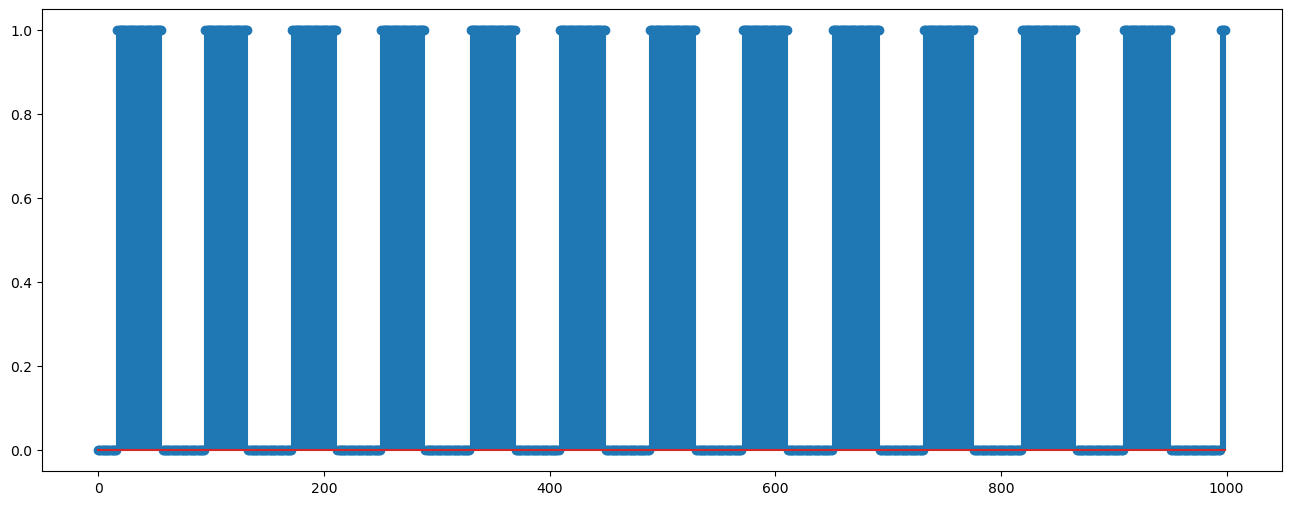

In [5]:
# data_df_g.head
labelssteps2 = labelssteps[5000:6000]
fig, (ax) = plt.subplots(1,figsize = (16,6))

# Assuming your columns are named 'col1', 'col2', ..., 'col6'

ax.plot(labelssteps2, label='Activity')


plt.show()


In [6]:
scaler = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scaler.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDatasetLSTM(training_data_scaled,time_steps=40)
train_data_scaled, test_data_scaled = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


## Graphing

In [7]:
labels_df = pd.DataFrame(training_data[1].numpy())
data_df = pd.DataFrame(data_scaled.numpy())

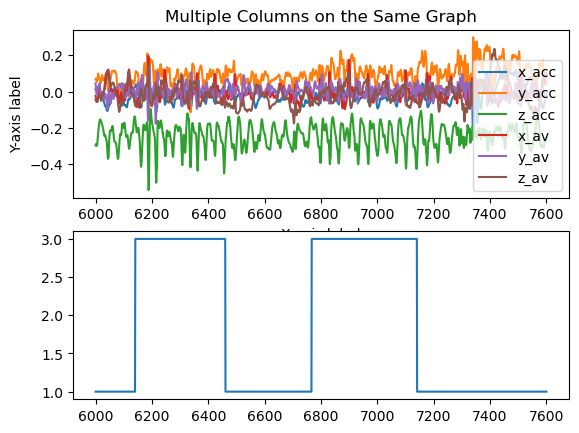

In [8]:

# print(data_df)
size_w = 1600
a_begin = 6000
aend = a_begin+size_w
data_df_g = data_df.loc[a_begin:aend]
labels_df_g = labels_df.loc[a_begin:aend]

# Assuming you have a DataFrame named 'df' and a list of new column names
new_column_names = ['x_acc', 'y_acc', 'z_acc', 'x_av', 'y_av', 'z_av']
new_column_names_labels = ['activity']

# Assign the new column names to the DataFrame
data_df_g.columns = new_column_names
labels_df_g.columns = new_column_names_labels
# data_df_g.head

fig, (ax,ax1) = plt.subplots(2,1)

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(data_df_g['x_acc'], label='x_acc')
ax.plot(data_df_g['y_acc'], label='y_acc')
ax.plot(data_df_g['z_acc'], label='z_acc')
ax.plot(data_df_g['x_av'], label='x_av')
ax.plot(data_df_g['y_av'], label='y_av')
ax.plot(data_df_g['z_av'], label='z_av')

ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Multiple Columns on the Same Graph')
ax.legend()

ax1.plot(labels_df_g['activity'], label='Activity')

plt.show()


## MLP

1 Iteration - Loss:  {1.107177452112461}


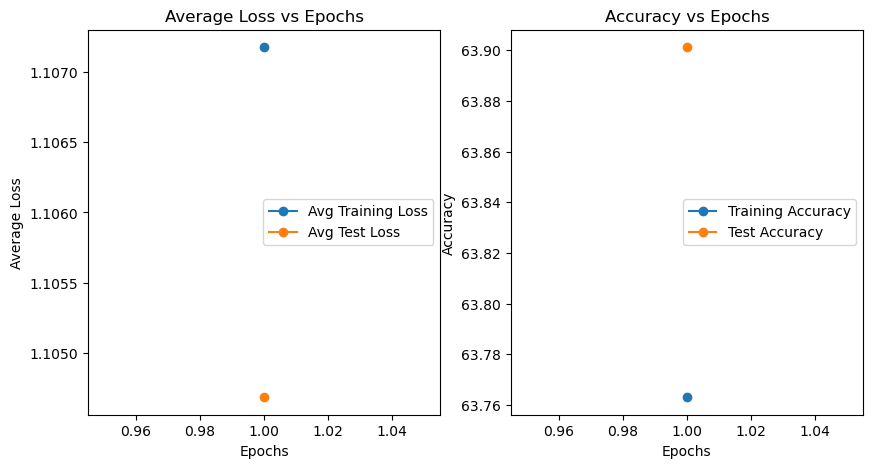

In [56]:
epochs = 1
b_size = 10
hidden_dims = [100,50,10]
lr = 0.005

model,losses,plot = mlp_train(train_data,hidden_dims,epochs,b_size,lr,False,True,feature_dim,class_dim,test_data)

## LSTM for Activity detection

In [67]:
# Example usage
batch_size = 64

dataloader = DataLoader(train_data_scaled, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled, batch_size=batch_size, shuffle=False,drop_last= True)

class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sfm = nn.Softmax(dim = 1)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        #out = self.fc(hn.squeeze(0))
        # print(f'out is now {out.shape}')
        out = out[:, -1, :]
        # print(f'out is now 2 {out.shape}')
        out = self.fc(out)
        # print(f'out is now 3 {out.shape}')
        #out = self.sfm(out)
        # out = torch.argmax(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

print('Preparing datasets')

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

lr = 0.01
n_epochs = 15
# iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')
# print('dataloader', dataloader)
# sequence_length = 10

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch_v.size(0)
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


Preparing datasets
Start model training
Accuracy epoch 1 90.39%
Epoch 1 best model saved with accuracy: 90.39%
Accuracy epoch 2 93.42%
Epoch 2 best model saved with accuracy: 93.42%
Accuracy epoch 3 63.87%
Accuracy epoch 4 63.71%
Accuracy epoch 5 63.95%
Epoch:   5. Loss: 1.1587. Acc.: 63.95%
Accuracy epoch 6 63.94%
Accuracy epoch 7 63.30%
Early stopping on epoch 7


## LSTM for Step prediction

In [145]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [146]:
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=40)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [103]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [105]:
dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

lr = 0.01
n_epochs = 15
best_acc = 0
patience, trials = 8, 0

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Accuracy epoch 1 96.82%
Epoch 1 best model saved with accuracy: 96.82%
Accuracy epoch 2 97.06%
Epoch 2 best model saved with accuracy: 97.06%
Accuracy epoch 3 97.08%
Epoch 3 best model saved with accuracy: 97.08%
Accuracy epoch 4 96.45%
Accuracy epoch 5 96.44%
Epoch:   5. Loss: 0.1842. Acc.: 96.44%
Accuracy epoch 6 96.45%
Accuracy epoch 7 96.45%
Accuracy epoch 8 96.45%
Accuracy epoch 9 96.40%
Accuracy epoch 10 96.45%
Epoch:  10. Loss: 0.1622. Acc.: 96.45%
Accuracy epoch 11 96.45%
Early stopping on epoch 11


## Activity prediction

In [125]:
path_activity_model = 'best_activity_lstm.pth'

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_activity_model))

test_data = torch.tensor(dataframe.values)
test_data_scaled_act = torch.tensor(scaler.transform(test_data))
test_data_scaled_act = test_data_scaled_act.float()


dataset = MyDatasetLSTM_testing(test_data_scaled_act,time_steps=40)

# # Set the batch size
batch_size = 32

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = []

# Disable gradient calculation
k=0
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        y_pred = pred_probab.argmax(1)
        if(y_pred.shape[0]!= 32):
            print(f'shape {y_pred.shape} k: {k}')
        k+=1
        # print(f"Predicted class: {y_pred}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # break
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        predicted_labels.extend(y_pred)


shape torch.Size([4]) k: 3189


## Step prediction

In [191]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data_w_act))
test_data_scaled_steps = test_data_scaled_steps.float()



# print(test_data_w_act.shape)

/var/folders/8g/zrqn7yqx5yvgtqtt793z3p5m0000gn/T/ipykernel_1375/895000160.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activity_label = torch.cat((torch.tensor(activity_label),zeros_pad),dim=0)


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [193]:
path_steps_model = 'best_steps_lstm.pth'

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        # y_pred = pred_probab.argmax(1)
        mat = pred_probab[0,(1,2),:]
        mat = torch.permute(mat,[1,0])
        if(mat.shape[0]!=40):
            print(y)
            print(mat.shape[0])
        predicted_labels = torch.cat((predicted_labels,mat),dim = 0)
        y+=1
        # print(f"Predicted class: {pred_probab} {pred_probab.shape}")
        # print(f"Result class: {predicted_labels} {predicted_labels.shape}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        # predicted_labels.extend(y_pred)


In [194]:
zeros_pad = torch.zeros((11,2))
predicted_labels = torch.cat((predicted_labels,zeros_pad),dim=0)
print(f"Predicted class: {predicted_labels} {predicted_labels.shape}")


Predicted class: tensor([[5.2765e-04, 2.4150e-04],
        [7.2719e-05, 1.1153e-04],
        [5.0461e-05, 2.3108e-04],
        ...,
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]]) torch.Size([102091, 2])


In [18]:
from sklearn.ensemble import RandomForestClassifier

X = train_data[:][0]
y = train_data[:][1]
X_test = test_data[:][0]
y_test = test_data[:][1]

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X, y)

print("Score with training data: ",round(clf.score(X,y),4))
print("Score with test data: ",round(clf.score(X_test,y_test),4))



Score with training data:  0.7248
Score with test data:  0.7243
R^2 train:  0.6377432021493313
R^2 test:  0.6384752499363395


/Users/rodolfocacacho/opt/anaconda3/envs/python_env_ann/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 Iteration - Loss:  {0.5871667010535466}
2 Iteration - Loss:  {0.5870351438821999}
3 Iteration - Loss:  {0.5870319525644411}
4 Iteration - Loss:  {0.5870306758748371}
5 Iteration - Loss:  {0.587029990234588}


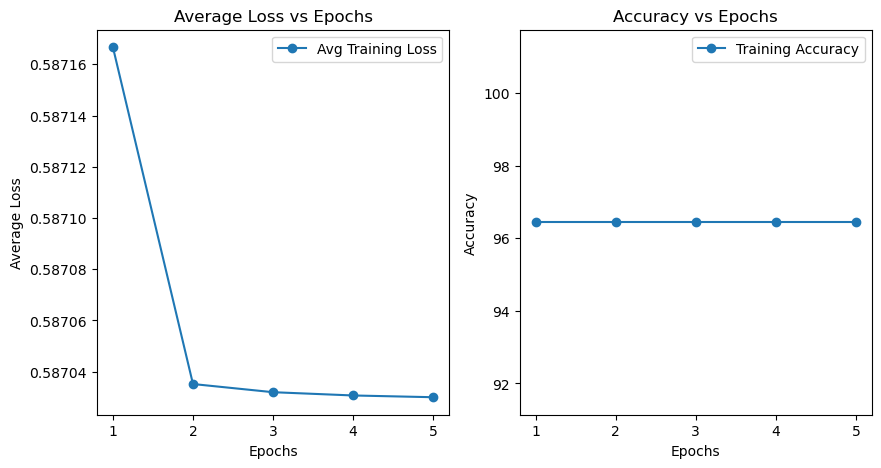

In [3]:
from mlp_helper import mlp_train

train_data = tensor_unified[:, torch.arange(tensor_unified.size(1)) != 0]
train_data = train_data.to(torch.float32)
hidden_dims = [10]
epochs = 5
batch_size = 10
learning_rate = 0.08
cuda = False
plots = True
test_data = test_data.to(torch.float32)

mlp_model, losses,plot = mlp_train(train_data,hidden_dims, epochs, batch_size, learning_rate, cuda, plots,test_data)

In [4]:
with torch.no_grad():
    test_preds = mlp_model(test_data)

In [5]:
test_preds.shape

torch.Size([102091, 3])

In [195]:
# Assuming your tensor is named 'tensor_data'
# Convert the tensor to a NumPy array

# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = predicted_labels.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_40_step_length_mdw.csv')

In [199]:
df.start

index
0         0.000528
1         0.000073
2         0.000050
3         0.000112
4         0.000126
            ...   
102086    0.000000
102087    0.000000
102088    0.000000
102089    0.000000
102090    0.000000
Name: start, Length: 102091, dtype: float32

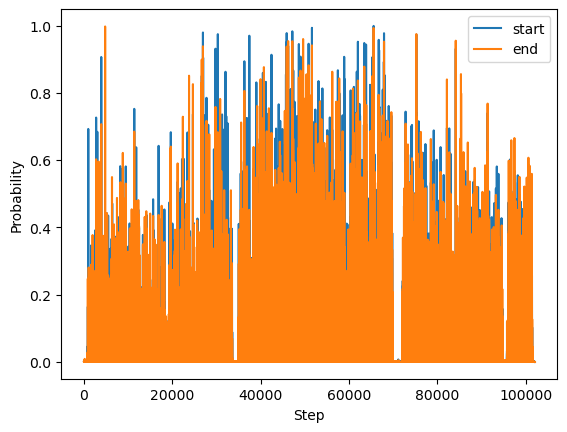

In [200]:
fig, ax = plt.subplots(1)

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(df.start, label='start')
ax.plot(df.end, label='end')

ax.set_xlabel('Step')
ax.set_ylabel('Probability')
ax.legend()


plt.show()

### Test preprocessing


In [ ]:
folder_path = os.getcwd()+'/data/'
print(folder_path)
subdirectories = get_subdirectories(folder_path)
print(subdirectories)

file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']
tensors = {}

for i in subdirectories:
    folder_i = folder_path+i
    files_t = get_files_in_subdirectories(folder_i)
    files_n = list(dict.fromkeys(get_num(files_t)))
    for index_j,j in enumerate(files_n):
        name_variable = i+'_'+str(index_j)
        for index_k,k in enumerate(file_extension):
            files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
            name_variableR = i+'_'+j+'_'+label[index_k]
            # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
            if index_k == 0:
                main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
            else:
                label_df = pd.read_csv(files[0],names = ['start','end'])
                label_df['start_end_index'] = label_df['start'] + 10
                label_df['end_start_index'] = label_df['end'] - 10
                index_start = label_df.start.tolist()
                index_start_end = label_df.start_end_index.tolist()
                index_end = label_df.end.tolist()
                index_end_start = label_df.end_start_index.tolist()
                print(index_start_end)
        # Add a new column with a specific value for the matching row indexes
        main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
        # main_df['label1'] = main_df.apply(lambda row: 'start' if (int(row.name) >= int(index_start) and int(row.name) <= int(index_start_end)) else '', axis=1)
        main_df['label2'] = main_df.apply(lambda row: 'end' if (int(row.name) >= int(index_end_start) and int(row.name) <= int(index_end)) else '', axis=1)
        # Define the condition for the new column
        condition1 = main_df['label1'] == 'start'
        condition2 = main_df['label2'] == 'end'
        # Assign values based on the condition using np.where()
        main_df['label'] = np.where(condition1,1,
                                np.where(condition2,2,0))
        main_df = main_df.drop(['label1', 'label2'], axis=1)
        # print(main_df)
        # Convert DataFrame to a tensor
        tensor = torch.tensor(main_df.values)
        # Store the tensor in the dictionary with the specified variable name
        tensors[name_variable] = tensor

# Labels are:
# 0 - Neither start nor end
# 1 - Start
# 2 - End